# LGBIO2060 - Exercise session 4
 


## Import and helper functions
**Please execute the cell below to initialize the notebook environment**

In [7]:
#@title Imports
import numpy as np
import matplotlib.pyplot as plt

## Tutorial objectives 

At the end of this tutorial, you should be able to understand the 

# Section 1 - Model Formulation

In [8]:
N = 50  # Nb of steps

dt = 0.01
kv = 0.1
tau = 0.05
lamb = 0
ns = 10
A = np.array([(1, 0, dt, 0, 0, 0, 0, 0, 0, 0),
              (0, 1, 0, dt, 0, 0, 0, 0, 0, 0),
              (0, 0, 1 - dt * kv, 0, dt, 0, 0, 0, 0, 0),
              (0, 0, 0, 1 - dt * kv, 0, dt, 0, 0, 0, 0),
              (0, 0, 0, 0, 1 - (dt / tau), 0, 0, 0, 0, 0),
              (0, 0, 0, 0, 0, 1 - (dt / tau), 0, 0, 0, 0),
              (0, 0, 0, 0, 0, 0, 1, 0, 0, 0),
              (0, 0, 0, 0, 0, 0, 0, 1, 0, 0),
              (0, 0, 0, 0, 0, 0, 0, 0, 1, 0),
              (0, 0, 0, 0, 0, 0, 0, 0, 0, 1)])
B = np.array([(0, 0),
              (0, 0),
              (0, 0),
              (0, 0),
              (dt / tau, lamb * dt / tau),
              (lamb * dt / tau, dt / tau),
              (0, 0),
              (0, 0),
              (0, 0),
              (0, 0)])

## Section 2 - Cost Function

Define q and r

In [9]:
w1 = 100
w2 = 100
w3 = 10
w4 = 10
QN = np.array([(w1, 0, 0, 0, 0, 0, -w1, 0, 0, 0),
               (0, w2, 0, 0, 0, 0, 0, -w2, 0, 0),
               (0, 0, w3, 0, 0, 0, 0, 0, -w3, 0),
               (0, 0, 0, w4, 0, 0, 0, 0, 0, -w4),
               (0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
               (0, 0, 0, 0, 0, 0, 0, 0, 0, 0),
               (-w1, 0, 0, 0, 0, 0, w1, 0, 0, 0),
               (0, -w2, 0, 0, 0, 0, 0, w2, 0, 0),
               (0, 0, -w3, 0, 0, 0, 0, 0, w3, 0),
               (0, 0, 0, -w4, 0, 0, 0, 0, 0, w4)])
R = np.array([(10 ** -4, 0), (0, 10 ** -4)])

## Section 3 - Optimal Control

Now that our system is defined and that we have our cost function, we want to find the control sequence $u_1$, $u_2$, $u_3$, ... $u_n$ that minimizes the cost. From all the motor commands we can do to reach our goal, we want to find the most optimal. 

The solution of this problem ([proof here]()) is given by the following **backward** recursion.

\begin{eqnarray}
S_N &=& Q_N, \qquad s_N = 0,\\
L_k &=& \left(R+B^TS_{k+1}B\right)^{-1}B^TS_{k+1}A,\\
S_k &=& Q_k + A^TS_{k+1}(A-BL_k).
\end{eqnarray}

We can simulate the system forward since the control signal is defined as $u_k = -L_k x_k$, the dynamics becomes:

\begin{eqnarray}
x_{k+1} = (A-BL_k)x_k + \xi_k.
\end{eqnarray}

Where $\xi_k \sim \mathcal{N}(0,\Omega_{\xi})$, which corresponds to the noise on the motor command. The covariance matrix, $\Omega_{\xi}$, has very low values ( $10^{-4}$).

In [10]:
L = np.zeros((N, 2, ns))
S = np.zeros((N, ns, ns))
Q = np.zeros((N, ns, ns))
Q[N - 1, :, :] = QN
S[N - 1, :, :] = QN

for i in range(N - 1, 0, -1):
    L[i - 1, :, :] = np.linalg.inv(R + B.T @ S[i, :, :] @ B) @ B.T @ S[i, :, :] @ A 
    S[i - 1, :, :] = Q[i - 1] + A.T @ S[i, :, :] @ (A - B @ L[i - 1, :, :])


Using the control gains you have computed above, you can already simulate some movements, try to set a goal and run your code to see if this model behaves as you would expect.

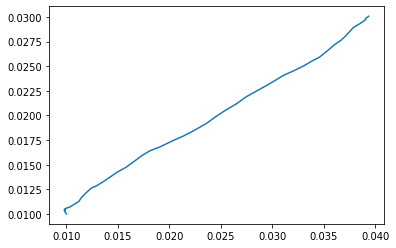

In [11]:
X = np.zeros((N, ns, 1))

#set a goal
X[0, :, :] = [[0.01], [0.01], [0], [0], [0], [0], [0.04], [0.03], [0], [0]]

#compute the motor noise 
Xi = np.random.normal(loc=0, scale=10 ** -4, size=(N, 10, 1))

#simulate the evolution of the state using the control gains previously computed
for j in range(0, N - 1):
    X[j + 1, :, :] = ((A - B @ L[j, :, :]) @ X[j, :, :]) + Xi[j, :, :]

plt.plot(X[:, 0, :],X[:, 1, :])

##Section 4 - State Estimation

Despite the good movements simulated by our model, this does not match with the reality. Indeed, we don't have access to the exact state of our body. We have to estimate it by combining sensory feedback information (visual, somatosensory, ... ) with the dynamics we know of our body. For example, when we contract a muscle we know that our limb will move, and we know approximatly how it will move.

Due to the uncertainty we have on both informations, we will combine them in an optimal and continuous way by using the **Kalman filter** we saw in the previous tutorial.

We will consider that the information we extracted from our sensory feedback can be defined as follow : 
\begin{eqnarray*}
y_k = Hx_k + \omega_k,
\end{eqnarray*}
with $\omega_k \sim \mathcal{N}(0,\Omega_{\omega})$ which corresponds to the sensory noise, the covariance matrix in this case will have values around $10^{-2}$. 

The kalman gains that allows us to combine these informations can be computed using the following forward recursion: 
\begin{eqnarray}
\Sigma_1, \hat{x}_1&&  \textrm{given}\\
K_{k} &=& A\Sigma_kH^T\left(H\Sigma_KH^T+\Omega_{\omega}\right)^{-1},\\
\Sigma_{k+1} &=& \Omega_{\xi} + (A-K_kH)\Sigma_k A^T\\
\hat{x}_{k+1} &=& A\hat{x}_k + B u_k + K_{k}\left(y_k - H\hat{x}_k\right).
\end{eqnarray}

Where $\Sigma_1 = 10^{-6} \mathbb{I}_n$.


Compare the results you obtained when adding feedback to the results you obtained earlier.



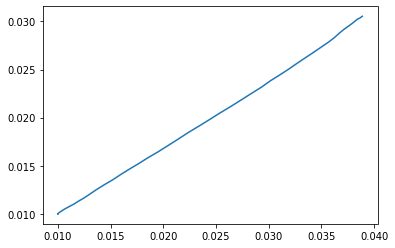

In [14]:
Xhat = np.zeros((N, ns, 1))
Xhat[0, :, :] = X[0, :, :]

Y = np.zeros((N, ns, 1))
U = np.zeros((N,2,1))

Sigma = np.zeros((N, ns, ns))
Sigma[0,:,:] = np.eye(ns)*10**-6

K = np.zeros((N, ns, ns))
H = np.eye(ns)

Xi = np.random.normal(loc=0, scale=10 ** -4, size=(N, ns, 1))
Omega = np.random.normal(loc=0, scale=10 ** -2, size=(N, ns, 1))
oXi = 0.1 * (B @ B.T)
oOmega = 0.1 * np.max(np.max(oXi)) * np.eye(ns)

for j in range(0, N - 1):
    X[j + 1, :, :] = ((A - B @ L[j, :, :]) @ X[j, :, :]) + Xi[j, :, :]
    Y[j, :, :] = H @ X[j] + Omega[j, :, :]
    K[j,:,:] = A @ Sigma[j,:,:] @ H.T @ np.linalg.inv(H@Sigma[j,:,:] @H.T + oOmega)
    Sigma[j + 1, :, :] = oXi + (A - K[j, :, :] @ H) @ Sigma[j, :, :] @ A.T
    U[j,:,:] = - L[j,:,:] @ Xhat[j,:,:]
    Xhat[j+1,:,:] = A @ Xhat[j,:,:] + B @ U[j,:,:] + K[j,:,:] @ (Y[j,:,:] - H @ Xhat[j,:,:] )

plt.plot(Xhat[:, 0, :],Xhat[:, 1, :])
plt.show()